In [15]:
pip install pandas numpy scikit-learn matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


# Player Clustering Based on Bustabit Game Data

This notebook aims to cluster players based on their behavior in the Bustabit game dataset. The pipeline includes data preprocessing, feature engineering, exploratory data analysis (EDA), feature scaling, dimensionality reduction using PCA, and KMeans clustering to group players into distinct behavioral categories. Additionally, it includes handling NaN values and infinite values, which are common in real-world datasets, using a robust imputation strategy to ensure clean and reliable data.


## 1. Data Preprocessing

We start by loading the dataset and converting the `PlayDate` column to a proper datetime format. 

- **NaN Checking**: We print out which columns contain NaN values to understand where data is missing.
- **NaN Handling**: We fill missing values in the 'CashedOut' column with 0, assuming NaN represents games where the player didn’t cash out.
- **Error Prevention**: This step ensures that missing values don’t disrupt the analysis pipeline later on.

In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns


In [17]:
# 1. Data Preprocessing
def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    df['PlayDate'] = pd.to_datetime(df['PlayDate'])
    
    # Check for NaN values
    print("Columns with NaN values:")
    print(df.isnull().sum())
    
    # Handle NaN values in 'CashedOut' column
    df['CashedOut'] = df['CashedOut'].fillna(0)  # Assume 0 for non-cashed out games
    
    return df


## 2. Feature Engineering
In this section, we create features that describe each player’s behavior. This includes calculating the average bet size, total profit, risk tolerance, and win rate.

Handling Infinite Values: We replace infinite values, which can occur from division, with NaN.
Imputation: Remaining NaN values are imputed using the mean of each feature.

In [4]:
# 2. Feature Engineering
def engineer_features(df):
    player_features = df.groupby('Username').agg({
        'Bet': ['mean', 'std', 'sum', 'count'],
        'CashedOut': ['mean', 'std'],
        'Profit': ['mean', 'sum'],
        'BustedAt': ['mean'],
        'Bonus': ['mean', 'sum']
    })
    player_features.columns = ['_'.join(col).strip() for col in player_features.columns.values]
    
    # Calculate risk tolerance (std of CashedOut / mean of CashedOut)
    player_features['risk_tolerance'] = player_features['CashedOut_std'] / player_features['CashedOut_mean']
    player_features['win_rate'] = player_features['Profit_sum'] / player_features['Bet_sum']
    
    # Handle potential NaN or inf values from division
    player_features = player_features.replace([np.inf, -np.inf], np.nan)
    
    # Impute NaN values
    imputer = SimpleImputer(strategy='mean')
    player_features_imputed = pd.DataFrame(imputer.fit_transform(player_features), 
                                           columns=player_features.columns, 
                                           index=player_features.index)
    
    return player_features_imputed


## 3. Exploratory Data Analysis (EDA)
We perform exploratory data analysis by visualizing the correlation between different features. This step helps us identify potential relationships between variables before applying clustering.

In [5]:
# 3. EDA (simplified for brevity)
def perform_eda(player_features):
    correlation = player_features.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation, annot=True, cmap='coolwarm')
    plt.title('Feature Correlation Heatmap')
    plt.show()


## 4. Feature Scaling
Before applying PCA and KMeans, it's essential to scale the features. We use the StandardScaler to normalize the data to have a mean of 0 and a standard deviation of 1. This ensures that all features contribute equally to the clustering process.


In [6]:
# 4. Feature Scaling
def scale_features(player_features):
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(player_features)
    return scaled_features, scaler


## 5. Dimensionality Reduction with PCA
Since clustering in high dimensions can be challenging, we reduce the feature set using PCA (Principal Component Analysis). PCA helps in capturing the most important information while reducing noise and redundant features.



In [7]:
# 5. Dimensionality Reduction
def apply_pca(scaled_features, n_components=0.95):
    pca = PCA(n_components=n_components)
    pca_features = pca.fit_transform(scaled_features)
    return pca_features, pca


## 6. KMeans Clustering
We apply KMeans clustering to the reduced features. To determine the optimal number of clusters, we use the "elbow method," which plots the inertia (sum of squared distances to cluster centers) for different numbers of clusters. The elbow point represents the optimal number of clusters.

In [8]:
# 6. Clustering
def apply_kmeans(pca_features, max_clusters=10):
    inertias = []
    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(pca_features)
        inertias.append(kmeans.inertia_)
    
    # Plot elbow curve
    plt.plot(range(1, max_clusters + 1), inertias, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')
    plt.show()
    
    # Choose optimal k (you may need to adjust this based on the elbow curve)
    optimal_k = 3  # This is an example, adjust based on the elbow curve
    
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    cluster_labels = kmeans.fit_predict(pca_features)
    return cluster_labels, kmeans


## 7. Cluster Analysis and Interpretation
We analyze the clusters by calculating the mean of each feature for each cluster. This gives us insight into the characteristics of different player segments. For example, we may label clusters as "Risk-takers", "Conservative players", and "Balanced players" based on their betting behavior.

In [9]:
# 7. Cluster Analysis and Interpretation
def analyze_clusters(player_features, cluster_labels):
    player_features['Cluster'] = cluster_labels
    cluster_means = player_features.groupby('Cluster').mean()
    print("Cluster Means:")
    print(cluster_means)
    
    # Visualize clusters (example using two features)
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=player_features, x='Bet_mean', y='CashedOut_mean', hue='Cluster', palette='deep')
    plt.title('Player Clusters: Bet Mean vs CashedOut Mean')
    plt.show()


## 8. Assign Player Types
Based on the clusters, we can assign meaningful labels to each cluster, such as "Risk-takers", "Conservative players", and "Balanced players", to understand different behavioral patterns.



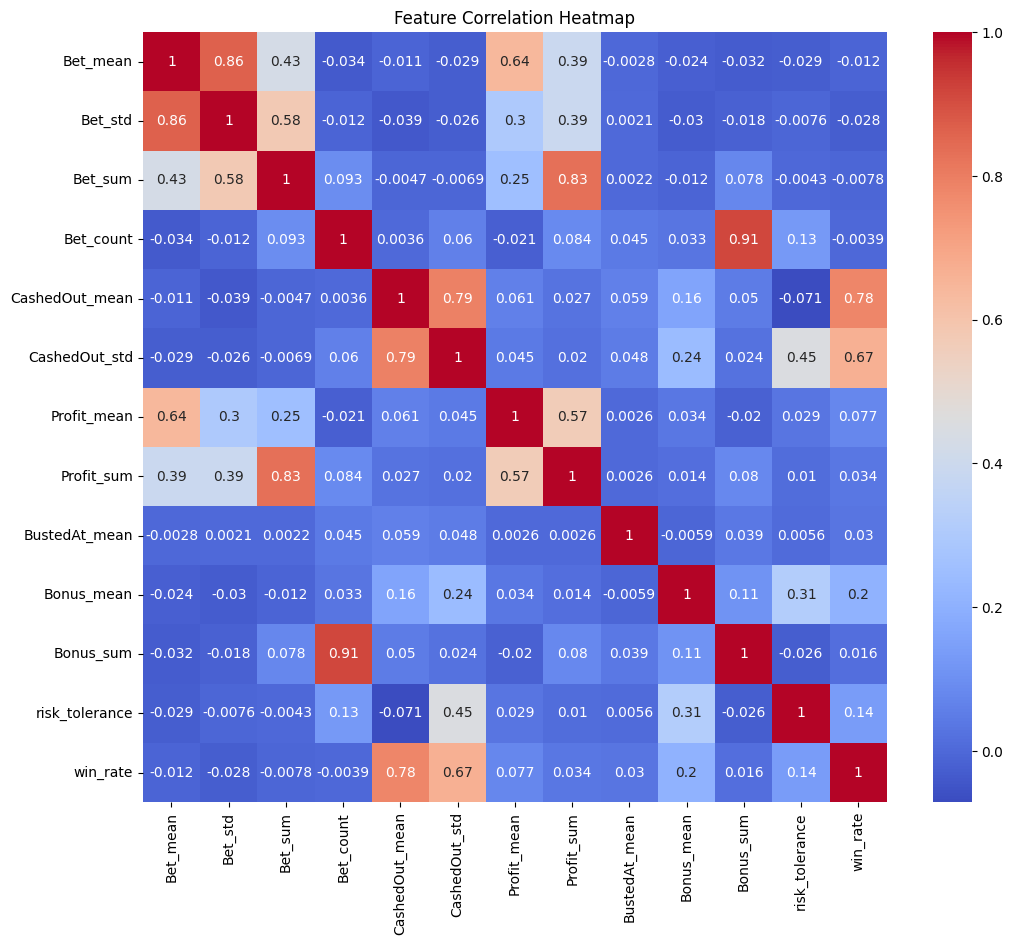

ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [14]:
# Main execution
if __name__ == "__main__":
    file_path = "bustabit.csv"
    
    # Execute the pipeline
    df = load_and_preprocess_data(file_path)
    player_features = engineer_features(df)
    perform_eda(player_features)
    scaled_features, _ = scale_features(player_features)
    pca_features, _ = apply_pca(scaled_features)
    cluster_labels, _ = apply_kmeans(pca_features)
    analyze_clusters(player_features, cluster_labels)

    # Interpret results and assign cluster labels
    cluster_interpretations = {
        0: "Risk-takers",
        1: "Conservative players",
        2: "Balanced players"
    }
    
    player_features['PlayerType'] = player_features['Cluster'].map(cluster_interpretations)
    print(player_features[['PlayerType']].value_counts())

    # Save results
    player_features.to_csv("player_clusters.csv")


## Conclusion
